# Multi-Class Classfication (w/ RandomForest, LGBM, Catboost)
- Revision history : 2024-06-28(init) / 2024-07-01

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install lightgbm==3.3.2

In [3]:
!pip install catboost

In [4]:
!pip install xgboost

In [5]:
!pip install mlxtend

In [6]:
# basic imports

import os
import sys
import time
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from scipy import stats
import openpyxl
from mlxtend .frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm


In [7]:
# visualization

import matplotlib.pyplot as plt
from matplotlib import font_manager, rcParams, style
import seaborn as sns

style.use('seaborn')

In [8]:
# ML imports

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import load_iris, load_digits

# lgbm
import lightgbm as lgb

# catboost
import catboost
from catboost import CatBoostClassifier, Pool

# xgboost
import xgboost as xgb

# smote
from imblearn.over_sampling import SMOTE

In [9]:
print(lgb.__version__)
print(catboost.__version__)
print(xgb.__version__)

3.3.2
1.2.5
2.0.3


In [10]:
os.chdir('/content/drive/MyDrive')
os.getcwd()

'/content/drive/MyDrive'

In [11]:
df = pd.read_csv('bodyPerformance.csv')
df.head()

,age,gender,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,27.0,M,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,25.0,M,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,31.0,M,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,32.0,M,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,28.0,M,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      13393 non-null  float64
 1   gender                   13393 non-null  object 
 2   height_cm                13393 non-null  float64
 3   weight_kg                13393 non-null  float64
 4   body fat_%               13393 non-null  float64
 5   diastolic                13393 non-null  float64
 6   systolic                 13393 non-null  float64
 7   gripForce                13393 non-null  float64
 8   sit and bend forward_cm  13393 non-null  float64
 9   sit-ups counts           13393 non-null  float64
 10  broad jump_cm            13393 non-null  float64
 11  class                    13393 non-null  object 
dtypes: float64(10), object(2)
memory usage: 1.2+ MB
None


In [13]:
print(df.isnull().sum())

age                        0
gender                     0
height_cm                  0
weight_kg                  0
body fat_%                 0
diastolic                  0
systolic                   0
gripForce                  0
sit and bend forward_cm    0
sit-ups counts             0
broad jump_cm              0
class                      0
dtype: int64


In [14]:
df1 = df.copy()
cols = df1.columns.tolist()[1:2] + df1.columns.tolist()[-1:]

for i in cols :
  print(df1[i].value_counts().sort_index())
  print("\n")

gender
F    4926
M    8467
Name: count, dtype: int64


class
A    3348
B    3347
C    3349
D    3349
Name: count, dtype: int64




In [15]:
def onehot(df, *args) :
  list_cols = []

  for i, cols in enumerate(args) :
    list_cols.append(cols)
    df_cols = df[[cols]]
    globals()['onehot{}'.format(i+1)] = pd.get_dummies(df_cols, prefix=cols)

  for i in range(len(list_cols)) :
    if i == 0 :
      onehot_concat = globals()['onehot{}'.format(i+1)]
    else :
      onehot_concat = pd.concat([onehot_concat, globals()['onehot{}'.format(i+1)]], axis=1)

  return onehot_concat

In [16]:
df_onehot = onehot(df1, 'gender')
df_onehot.head()

,gender_F,gender_M
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


In [17]:
df_onehot = df_onehot.apply(lambda x : x.astype('int'))
df_onehot.head()

,gender_F,gender_M
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1


In [18]:
df2 = df1.copy()

df2 = pd.concat([df_onehot, df2], axis=1)
df2 = df2.drop(columns=['gender'])
df2.head()

,gender_F,gender_M,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,0,1,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,0,1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,0,1,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,0,1,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,0,1,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [19]:
print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13393 entries, 0 to 13392
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   gender_F                 13393 non-null  int64  
 1   gender_M                 13393 non-null  int64  
 2   age                      13393 non-null  float64
 3   height_cm                13393 non-null  float64
 4   weight_kg                13393 non-null  float64
 5   body fat_%               13393 non-null  float64
 6   diastolic                13393 non-null  float64
 7   systolic                 13393 non-null  float64
 8   gripForce                13393 non-null  float64
 9   sit and bend forward_cm  13393 non-null  float64
 10  sit-ups counts           13393 non-null  float64
 11  broad jump_cm            13393 non-null  float64
 12  class                    13393 non-null  object 
dtypes: float64(10), int64(2), object(1)
memory usage: 1.3+ MB
None


In [20]:
corr = df2.iloc[:,:-1].corr()

corr_pairs = corr.stack().reset_index()
corr_pairs.columns = ['features1', 'features2', 'corr']

corr_pairs = corr_pairs[corr_pairs['features1'] != corr_pairs['features2']].sort_values('corr', ascending=False).reset_index(drop=True)
corr_pairs.head(10)

,features1,features2,corr
0,gender_M,gripForce,0.800184
1,gripForce,gender_M,0.800184
2,broad jump_cm,sit-ups counts,0.748273
3,sit-ups counts,broad jump_cm,0.748273
4,broad jump_cm,gripForce,0.746853
5,gripForce,broad jump_cm,0.746853
6,height_cm,gripForce,0.735024
7,gripForce,height_cm,0.735024
8,height_cm,weight_kg,0.734909
9,weight_kg,height_cm,0.734909


In [21]:
highcorr = corr_pairs[corr_pairs['corr'] > 0.9]
highcorr

,features1,features2,corr


In [22]:
highcorr['sort'] = highcorr.apply(lambda row : tuple(sorted([row['features1'], row['features2']])), axis=1)

highcorr = highcorr.drop_duplicates(subset=['sort']).drop(columns=['sort'])
highcorr.head()
print(len(highcorr))

0


In [23]:
list1 = highcorr['features1'].tolist()
list2 = highcorr['features2'].tolist()

list12 = list1 + list2

seen = set()
ulist = [x for x in list12 if not (x in seen or seen.add(x))]
print(ulist)

[]


In [24]:
df3 = df2.drop(columns=ulist)
df3.head()

,gender_F,gender_M,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,class
0,0,1,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,C
1,0,1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,A
2,0,1,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,C
3,0,1,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,B
4,0,1,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,B


In [25]:
dff = df3.copy()

dff['target'] = dff['class'].replace({'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3})
dff = dff.drop(columns=['class'])

dff.head()

,gender_F,gender_M,age,height_cm,weight_kg,body fat_%,diastolic,systolic,gripForce,sit and bend forward_cm,sit-ups counts,broad jump_cm,target
0,0,1,27.0,172.3,75.24,21.3,80.0,130.0,54.9,18.4,60.0,217.0,2
1,0,1,25.0,165.0,55.80,15.7,77.0,126.0,36.4,16.3,53.0,229.0,0
2,0,1,31.0,179.6,78.00,20.1,92.0,152.0,44.8,12.0,49.0,181.0,2
3,0,1,32.0,174.5,71.10,18.4,76.0,147.0,41.4,15.2,53.0,219.0,1
4,0,1,28.0,173.8,67.70,17.1,70.0,127.0,43.5,27.1,45.0,217.0,1


In [26]:
# random forest

X = dff.iloc[:, :-1]
y = dff.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

rfmodel = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators' : [100, 200],
    'max_depth' : [4, 8],
    'min_samples_split' : [2, 4]
}

grid_search = GridSearchCV(estimator=rfmodel, param_grid=param_grid, cv=3, n_jobs=1, verbose=2)
grid_search.fit(X_train, y_train)

best_rfmodel = grid_search.best_estimator_
print(best_rfmodel)
print(best_rfmodel.get_params())

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=200; total time=   1.1s
[CV] END .max_depth=4, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END .max_depth=4, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_split=4, n_estimators=100; total time=   0.5s
[CV] END .max_depth=4, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END .max_depth=4, min_samples_split=4, n_estimators=200; total time=   1.0s
[CV] END .max_depth=4, min_samples_split=4, n_est

In [27]:
rfmodel = RandomForestClassifier(max_depth=8, min_samples_split=4, n_estimators=200, random_state=42)
rfmodel.fit(X_train, y_train)

RandomForestClassifier(max_depth=8, min_samples_split=4, n_estimators=200,
                       random_state=42)

In [28]:
val_pred = rfmodel.predict(X_val)

val_accuracy = accuracy_score(y_val, val_pred)
val_conf_matrix = confusion_matrix(y_val, val_pred)
val_class_report = classification_report(y_val, val_pred, output_dict=True)

val_df_report = pd.DataFrame(val_class_report).transpose()

print(f'Accuracy : {val_accuracy}')
print(f'confusion matrix : \n {val_conf_matrix}')
print(f'classification report : \n {val_df_report}')

Accuracy : 0.7033349925335988
confusion matrix : 
 [[399  97   1   3]
 [110 276  85  19]
 [ 45  94 308  35]
 [ 11  29  67 430]]
classification report : 
               precision    recall  f1-score      support
0              0.706195  0.798000  0.749296   500.000000
1              0.556452  0.563265  0.559838   490.000000
2              0.668113  0.639004  0.653234   482.000000
3              0.882957  0.800745  0.839844   537.000000
accuracy       0.703335  0.703335  0.703335     0.703335
macro avg      0.703429  0.700254  0.700553  2009.000000
weighted avg   0.707783  0.703335  0.704243  2009.000000


Accuracy : 0.7068193130910901
confusion matrix : 
 [[428 108   3   1]
 [112 270  71  23]
 [ 44  83 327  33]
 [  5  28  78 395]]
classification report : 
               precision    recall  f1-score      support
0              0.726655  0.792593  0.758193   540.000000
1              0.552147  0.567227  0.559585   476.000000
2              0.682672  0.671458  0.677019   487.000000
3              0.873894  0.780632  0.824635   506.000000
accuracy       0.706819  0.706819  0.706819     0.706819
macro avg      0.708842  0.702977  0.704858  2009.000000
weighted avg   0.711731  0.706819  0.708193  2009.000000


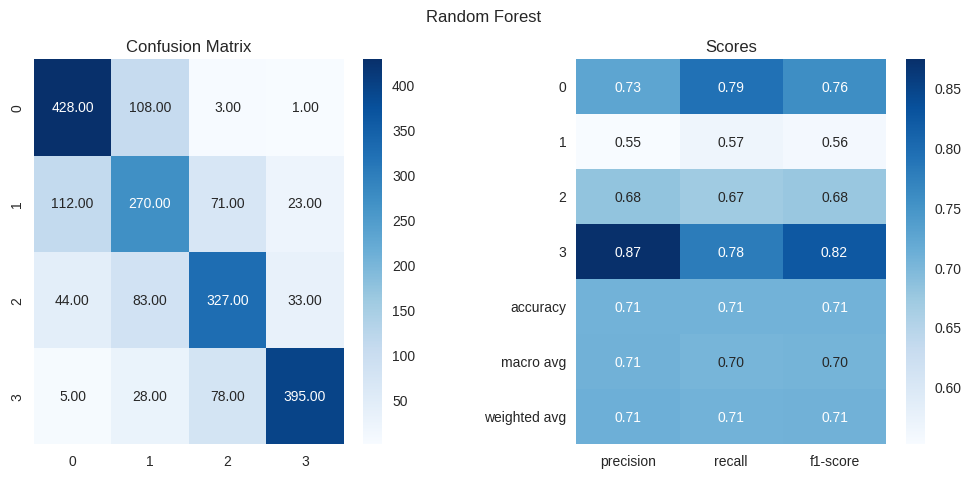

In [29]:
y_pred = rfmodel.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

df_report = pd.DataFrame(class_report).transpose()

print(f'Accuracy : {accuracy}')
print(f'confusion matrix : \n {conf_matrix}')
print(f'classification report : \n {df_report}')

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(df_report.iloc[:,:-1], annot=True, cmap='Blues', fmt='.2f')
plt.title('Scores')

plt.suptitle('Random Forest')
plt.subplots_adjust(wspace=0.4)
plt.show()

Training until validation scores don't improve for 10 rounds
[10]	train's multi_logloss: 0.83105	valid's multi_logloss: 0.867754
[20]	train's multi_logloss: 0.655614	valid's multi_logloss: 0.720847
[30]	train's multi_logloss: 0.568771	valid's multi_logloss: 0.662
[40]	train's multi_logloss: 0.510419	valid's multi_logloss: 0.631048
[50]	train's multi_logloss: 0.466001	valid's multi_logloss: 0.613748
[60]	train's multi_logloss: 0.430702	valid's multi_logloss: 0.60401
[70]	train's multi_logloss: 0.400668	valid's multi_logloss: 0.598894
[80]	train's multi_logloss: 0.373664	valid's multi_logloss: 0.594394
[90]	train's multi_logloss: 0.3499	valid's multi_logloss: 0.593426
Early stopping, best iteration is:
[89]	train's multi_logloss: 0.351863	valid's multi_logloss: 0.593208


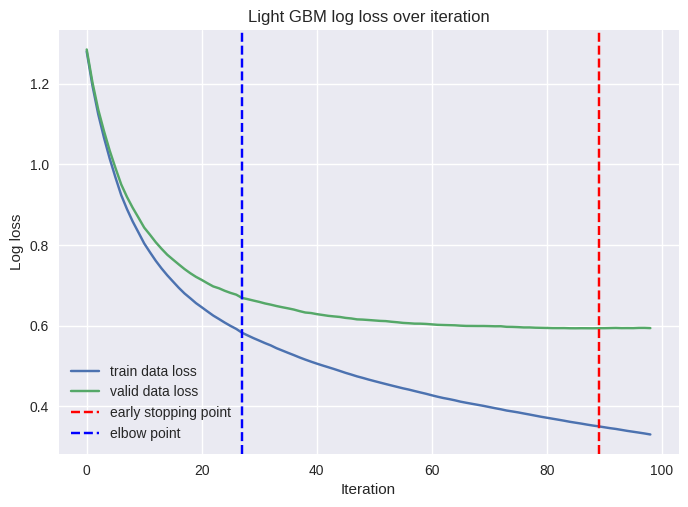

elbow point : 27
early stopping point : 89


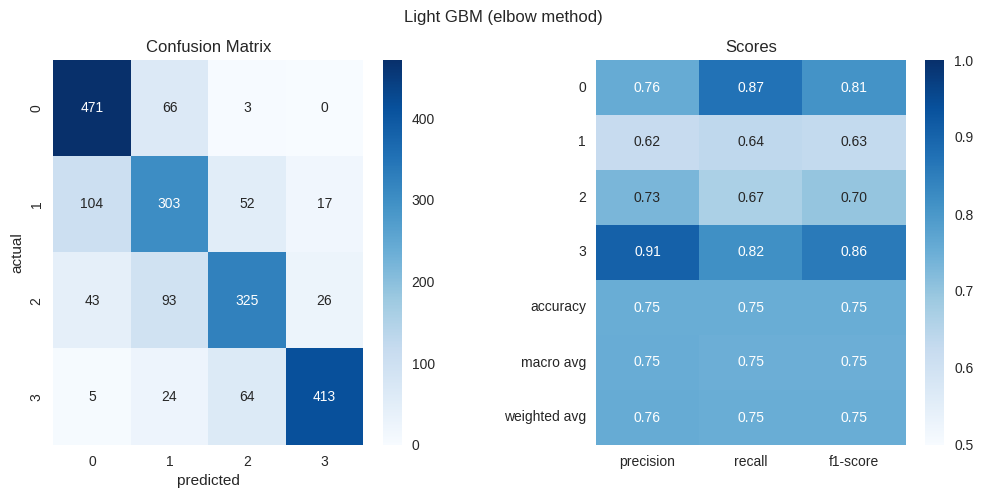

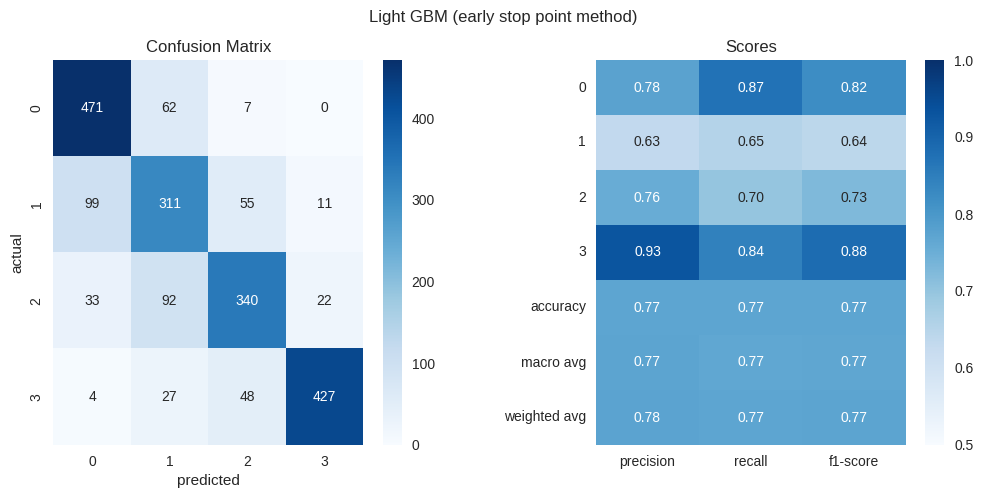



Accuracy (elbow method) : 0.7526132404181185
confusion matrix (elbow method) : 
 [[471  66   3   0]
 [104 303  52  17]
 [ 43  93 325  26]
 [  5  24  64 413]]
classification report (elbow method) : 
               precision    recall  f1-score      support
0              0.756019  0.872222  0.809974   540.000000
1              0.623457  0.636555  0.629938   476.000000
2              0.731982  0.667351  0.698174   487.000000
3              0.905702  0.816206  0.858628   506.000000
accuracy       0.752613  0.752613  0.752613     0.752613
macro avg      0.754290  0.748083  0.749178  2009.000000
weighted avg   0.756484  0.752613  0.752470  2009.000000


Accuracy (early stop point method) : 0.7710303633648581
confusion matrix (early stop point method) : 
 [[471  62   7   0]
 [ 99 311  55  11]
 [ 33  92 340  22]
 [  4  27  48 427]]
classification report (early stop point method) : 
               precision    recall  f1-score     support
0              0.775947  0.872222  0.821273   540.000

In [30]:
# lgbm

X = dff.iloc[:, :-1]
y = dff.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

params = {
    'objective' : 'multiclass', # 다중분류
    'num_class' : 4, # 클래스 수
    'metric' : 'multi_logloss', # 평가 메트릭. 다중클래스 로그손실 사용
    'learning_rate' : 0.1, # 학습률
    'num_leaves' : 31, # 하나의 트리가 가질 수 있는 최대 리프 수
    'feature_fraction' : 0.8,
    'verbose' : -1 } # 트리 학습시 무작위 선택하는 피처 비율

# training
# early_stopping_point : 일정 횟수동안 검증데이터셋의 성능이 개선되지 않을 경우 학습 중단시키는 기능 (과적합방지, 학습시간 단축)
num_round = 100
evals_result = {}

bst = lgb.train(params,
                train_data,
                num_round,
                valid_sets = [train_data, valid_data],
                valid_names = ['train','valid'],
                early_stopping_rounds = 10,
                evals_result = evals_result,
#                **callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.evals_result(evals_result=evals_result)]**),
                verbose_eval = 10
                )

earlystop_point = bst.best_iteration

# loss

train_loss = evals_result['train']['multi_logloss']
valid_loss = evals_result['valid']['multi_logloss']

epochs = len(valid_loss)
x_axis = range(0, epochs)

# elbow methods

diffs = np.diff(valid_loss) # 1차 차분
second_diffs = np.diff(diffs) # 2차 차분

elbow_point = np.argmin(second_diffs) + 2  # 인덱스차이 보정 위함

plt.plot(x_axis, train_loss, label='train data loss')
plt.plot(x_axis, valid_loss, label='valid data loss')

plt.axvline(x=earlystop_point, color='r', linestyle='--', label='early stopping point')
plt.axvline(x=elbow_point, color='b', linestyle='--', label='elbow point')

plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.title('Light GBM log loss over iteration')
plt.legend()
plt.show()

print(f'elbow point : {elbow_point}')
print(f'early stopping point : {earlystop_point}')

# predictions

y_pred1 = bst.predict(X_test, num_iteration=elbow_point)
y_pred_max1 = [list(x).index(max(x)) for x in y_pred1]

y_pred2 = bst.predict(X_test, num_iteration=earlystop_point)
y_pred_max2 = [list(x).index(max(x)) for x in y_pred2]

# evaluation

accuracy1 = accuracy_score(y_test, y_pred_max1)
accuracy2 = accuracy_score(y_test, y_pred_max2)

conf_matrix1 = confusion_matrix(y_test, y_pred_max1)
conf_matrix2 = confusion_matrix(y_test, y_pred_max2)

class_report1 = classification_report(y_test, y_pred_max1, output_dict=True)
class_report2 = classification_report(y_test, y_pred_max2, output_dict=True)

df_report1 = pd.DataFrame(class_report1).transpose()
df_report2 = pd.DataFrame(class_report2).transpose()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix1, annot=True, cmap='Blues', fmt='d')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(df_report1.iloc[:,:-1], annot=True, cmap='Blues', fmt='.2f', vmin=0.5, vmax=1)
plt.title('Scores')

plt.suptitle('Light GBM (elbow method)')
plt.subplots_adjust(wspace=0.4)
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix2, annot=True, cmap='Blues', fmt='d')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(df_report2.iloc[:,:-1], annot=True, cmap='Blues', fmt='.2f', vmin=0.5, vmax=1)
plt.title('Scores')

plt.suptitle('Light GBM (early stop point method)')
plt.subplots_adjust(wspace=0.4)
plt.show()

print("\n")

print(f'Accuracy (elbow method) : {accuracy1}')
print(f'confusion matrix (elbow method) : \n {conf_matrix1}')
print(f'classification report (elbow method) : \n {df_report1}')

print("\n")

print(f'Accuracy (early stop point method) : {accuracy2}')
print(f'confusion matrix (early stop point method) : \n {conf_matrix2}')
print(f'classification report (early stop point method) : \n {df_report2}')

0:	learn: 1.3184279	test: 1.3203140	best: 1.3203140 (0)	total: 60.7ms	remaining: 6.01s
10:	learn: 1.0110596	test: 1.0165660	best: 1.0165660 (10)	total: 181ms	remaining: 1.46s
20:	learn: 0.8959376	test: 0.9055446	best: 0.9055446 (20)	total: 293ms	remaining: 1.1s
30:	learn: 0.8336668	test: 0.8481504	best: 0.8481504 (30)	total: 400ms	remaining: 890ms
40:	learn: 0.7894884	test: 0.8071212	best: 0.8071212 (40)	total: 508ms	remaining: 732ms
50:	learn: 0.7589281	test: 0.7788998	best: 0.7788998 (50)	total: 619ms	remaining: 594ms
60:	learn: 0.7377602	test: 0.7622086	best: 0.7622086 (60)	total: 742ms	remaining: 474ms
70:	learn: 0.7185851	test: 0.7463515	best: 0.7463515 (70)	total: 849ms	remaining: 347ms
80:	learn: 0.7028614	test: 0.7349495	best: 0.7349495 (80)	total: 955ms	remaining: 224ms
90:	learn: 0.6872468	test: 0.7227889	best: 0.7227889 (90)	total: 1.06s	remaining: 105ms
99:	learn: 0.6727126	test: 0.7116661	best: 0.7116661 (99)	total: 1.18s	remaining: 0us

bestTest = 0.7116661325
bestIterati

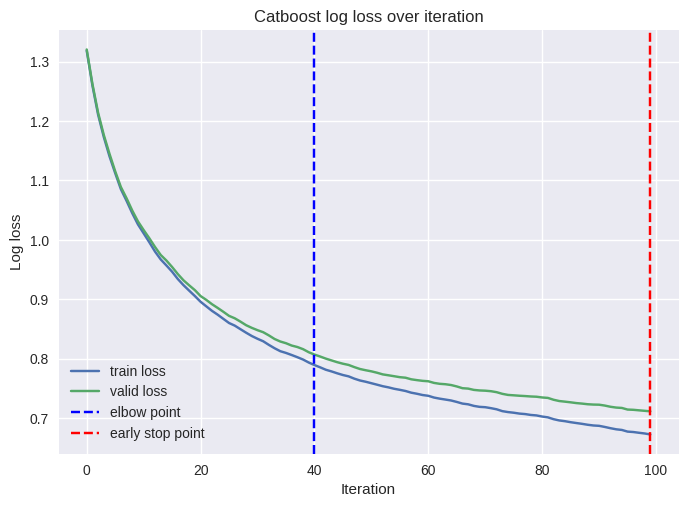

elbow point : 40
early stopping point : 99


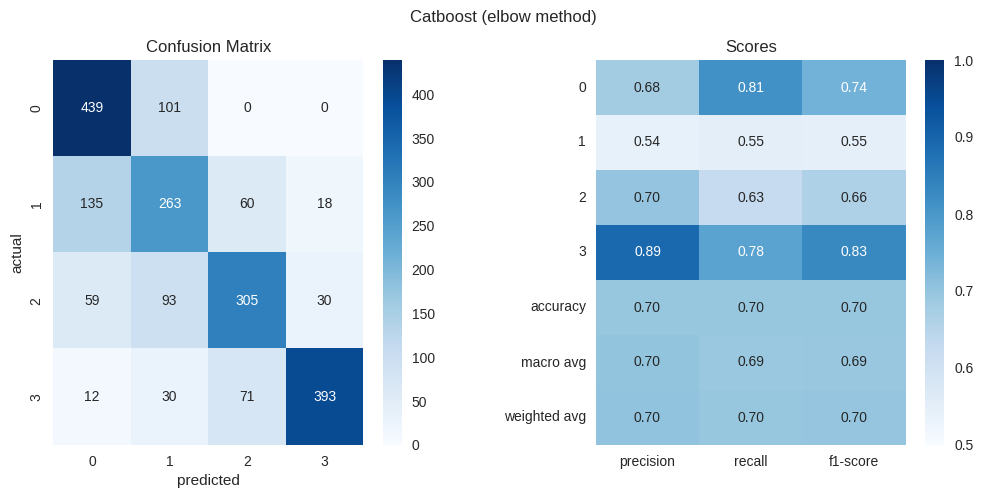

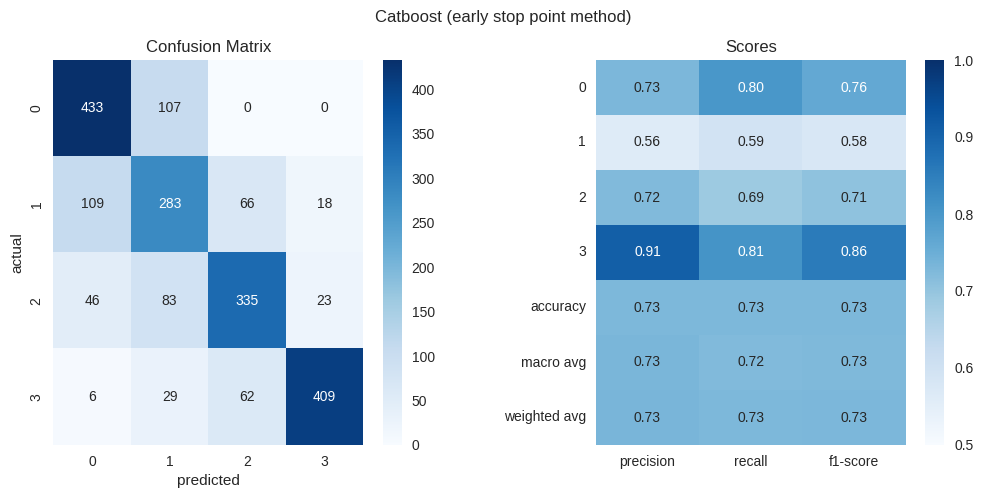



Accuracy (elbow method) : 0.6968641114982579
confusion matrix (elbow method) : 
 [[439 101   0   0]
 [135 263  60  18]
 [ 59  93 305  30]
 [ 12  30  71 393]]
classification report (elbow method) : 
               precision    recall  f1-score      support
0              0.680620  0.812963  0.740928   540.000000
1              0.540041  0.552521  0.546210   476.000000
2              0.699541  0.626283  0.660888   487.000000
3              0.891156  0.776680  0.829989   506.000000
accuracy       0.696864  0.696864  0.696864     0.696864
macro avg      0.702840  0.692112  0.694504  2009.000000
weighted avg   0.704926  0.696864  0.697822  2009.000000
Accuracy (early stop point method) : 0.7267297162767546
confusion matrix (early stop point method) : 
 [[433 107   0   0]
 [109 283  66  18]
 [ 46  83 335  23]
 [  6  29  62 409]]
classification report (early stop point method) : 
               precision    recall  f1-score     support
0              0.728956  0.801852  0.763668   540.00000

In [31]:
from catboost import CatBoostClassifier, Pool

X = dff.iloc[:, :-1]
y = dff.iloc[:, -1]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# MinMax Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# catboost pool 생성
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

params = {
    'iterations' : 100,
    'learning_rate' : 0.1,
    'depth' : 6,
    'loss_function' : 'MultiClass',
    'eval_metric' : 'MultiClass',
    'early_stopping_rounds' : 10,
    'random_seed' : 42,
    'verbose' : 10 # 10번째 iteration마다 출력
}

model = CatBoostClassifier(**params)

# train
model.fit(train_pool, eval_set=val_pool, plot=False, logging_level='Verbose')

evals_result = model.get_evals_result()
train_loss = evals_result['learn']['MultiClass']
valid_loss = evals_result['validation']['MultiClass']

# epochs = len(valid_loss)
# x_axis = range(epochs)

# elbow methods

diffs = np.diff(valid_loss) # 1차 차분
second_diffs = np.diff(diffs) # 2차 차분

elbow_point = 40
#elbow_point = np.argmin(second_diffs) + 2  # 인덱스차이 보정 위함
#elbow_point = np.argpartition(second_diffs, 2)[1]  # 더욱 안정적인 elbow point 계산 위함 (2차차분 값 중 두번째 작은 값의 인덱스)

# best iteration

earlystop_point = model.get_best_iteration()

# visualization

plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')

plt.axvline(x=elbow_point, color='b', linestyle='--', label='elbow point')
plt.axvline(x=earlystop_point, color='r', linestyle='--', label='early stop point')

plt.xlabel('Iteration')
plt.ylabel('Log loss')
plt.title('Catboost log loss over iteration')
plt.legend()
plt.show()

print(f'elbow point : {elbow_point}')
print(f'early stopping point : {earlystop_point}')

# prediction

y_pred1 = model.predict(X_test, ntree_end=elbow_point)
y_pred2 = model.predict(X_test, ntree_end=earlystop_point)

# evaluation
accuracy1 = accuracy_score(y_test, y_pred1)
accuracy2 = accuracy_score(y_test, y_pred2)

conf_matrix1 = confusion_matrix(y_test, y_pred1)
conf_matrix2 = confusion_matrix(y_test, y_pred2)

class_report1 = classification_report(y_test, y_pred1, output_dict=True)
class_report2 = classification_report(y_test, y_pred2, output_dict=True)

df_report1 = pd.DataFrame(class_report1).transpose()
df_report2 = pd.DataFrame(class_report2).transpose()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix1, annot=True, cmap='Blues', fmt='d')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(df_report1.iloc[:,:-1], annot=True, cmap='Blues', fmt='.2f', vmin=0.5, vmax=1)
plt.title('Scores')

plt.suptitle('Catboost (elbow method)')
plt.subplots_adjust(wspace=0.4)
plt.show()

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.heatmap(conf_matrix2, annot=True, cmap='Blues', fmt='d')
plt.xlabel('predicted')
plt.ylabel('actual')
plt.title('Confusion Matrix')

plt.subplot(1,2,2)
sns.heatmap(df_report2.iloc[:,:-1], annot=True, cmap='Blues', fmt='.2f', vmin=0.5, vmax=1)
plt.title('Scores')

plt.suptitle('Catboost (early stop point method)')
plt.subplots_adjust(wspace=0.4)
plt.show()

print("\n")

print(f'Accuracy (elbow method) : {accuracy1}')
print(f'confusion matrix (elbow method) : \n {conf_matrix1}')
print(f'classification report (elbow method) : \n {df_report1}')

print(f'Accuracy (early stop point method) : {accuracy2}')
print(f'confusion matrix (early stop point method) : \n {conf_matrix2}')
print(f'classification report (early stop point method) : \n {df_report2}')
